# Loop 8 Analysis: Understanding the Gap and Kuperberg Double-Lattice

## Key Insight from Research:
The Kuperberg & Kuperberg double-lattice construction finds the densest packing by:
1. Finding the optimal inscribed parallelogram in the polygon
2. Using its side vectors to generate two interlaced lattices
3. One lattice has copies of K, the other has copies of -K (180° rotated)

This is a MATHEMATICAL approach, not a heuristic search!

Tree polygon area: 0.245625
Tree polygon bounds: (-0.35, -0.2, 0.35, 0.8)


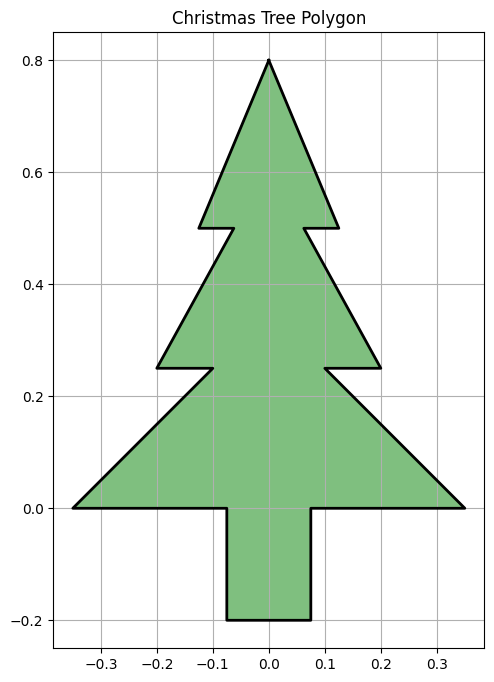

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely import affinity
import math

# Tree polygon vertices
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

# Create the tree polygon
tree_poly = Polygon(zip(TX, TY))
print(f'Tree polygon area: {tree_poly.area:.6f}')
print(f'Tree polygon bounds: {tree_poly.bounds}')

# Visualize the tree
fig, ax = plt.subplots(figsize=(6, 8))
x, y = tree_poly.exterior.xy
ax.fill(x, y, alpha=0.5, color='green')
ax.plot(x, y, 'k-', linewidth=2)
ax.set_aspect('equal')
ax.set_title('Christmas Tree Polygon')
ax.grid(True)
plt.show()

In [2]:
# Load current submission and analyze angle distributions
df = pd.read_csv('/home/submission/submission.csv')

def strip(s):
    return float(str(s).replace('s', ''))

df['N'] = df['id'].str.split('_').str[0].astype(int)
df['xf'] = df['x'].apply(strip)
df['yf'] = df['y'].apply(strip)
df['degf'] = df['deg'].apply(strip)

# Normalize angles to [0, 360)
df['degf_norm'] = df['degf'] % 360

# Check angle distribution for small N
print('=== Angle Distribution for Small N ===')
for n in range(1, 11):
    g = df[df['N'] == n]
    angles = g['degf_norm'].values
    print(f'N={n}: angles = {np.round(angles, 1)}')

# Check if angles follow 180° pattern (double-lattice signature)
print('\n=== Checking for 180° Rotation Pattern ===')
for n in range(2, 11):
    g = df[df['N'] == n]
    angles = g['degf_norm'].values
    # Count angles in [0, 90) and [180, 270)
    up_count = sum((a < 90) or (a >= 270) for a in angles)
    down_count = sum((90 <= a < 270) for a in angles)
    print(f'N={n}: up={up_count}, down={down_count}, ratio={up_count/n:.2f}')

=== Angle Distribution for Small N ===
N=1: angles = [45.]
N=2: angles = [203.6  23.6]
N=3: angles = [112.4  66.4 155.1]
N=4: angles = [156.4 156.4 336.4 336.4]
N=5: angles = [293.6  23.6 112.6  66.4 211.4]
N=6: angles = [293.6 338.9 338.9  23.6 246.4 158.9]
N=7: angles = [ 37.6 252.8  65.2 336.4 207.8 213.5  27.8]
N=8: angles = [ 51.8 113.6 293.6 203.6 231.8 293.6 113.6  23.6]
N=9: angles = [154.9 205.5  24.2 296.8 249.9 204.8 336.4 293.6 113.6]
N=10: angles = [290.2 338.6  21.4 292.6  70.4  23.6  66.3 336.3 115.6 246.3]

=== Checking for 180° Rotation Pattern ===
N=2: up=1, down=1, ratio=0.50
N=3: up=1, down=2, ratio=0.33
N=4: up=2, down=2, ratio=0.50
N=5: up=3, down=2, ratio=0.60
N=6: up=4, down=2, ratio=0.67
N=7: up=4, down=3, ratio=0.57
N=8: up=4, down=4, ratio=0.50
N=9: up=4, down=5, ratio=0.44
N=10: up=8, down=2, ratio=0.80


In [3]:
# Analyze the current best solutions for small N
# Compare with theoretical double-lattice predictions

def score_group(xs, ys, degs):
    n = len(xs)
    mnx, mny, mxx, mxy = 1e300, 1e300, -1e300, -1e300
    for i in range(n):
        r = degs[i] * math.pi / 180.0
        c, s = math.cos(r), math.sin(r)
        for j in range(15):
            X = c*TX[j] - s*TY[j] + xs[i]
            Y = s*TX[j] + c*TY[j] + ys[i]
            mnx = min(mnx, X)
            mxx = max(mxx, X)
            mny = min(mny, Y)
            mxy = max(mxy, Y)
    side = max(mxx - mnx, mxy - mny)
    return side * side / n, side

# Calculate scores for all N
results = []
for n, g in df.groupby('N'):
    xs = g['xf'].values
    ys = g['yf'].values
    ds = g['degf'].values
    score, side = score_group(xs, ys, ds)
    results.append({'N': n, 'score': score, 'side': side})

results_df = pd.DataFrame(results)
print('=== Current Scores for Small N ===')
print(results_df[results_df['N'] <= 20].to_string())

# Calculate total
total = results_df['score'].sum()
print(f'\nTotal score: {total:.6f}')
print(f'Target: 68.919154')
print(f'Gap: {total - 68.919154:.6f}')

=== Current Scores for Small N ===


     N     score      side
0    1  0.661250  0.813173
1    2  0.450779  0.949504
2    3  0.434745  1.142031
3    4  0.416545  1.290806
4    5  0.416850  1.443692
5    6  0.399610  1.548438
6    7  0.399897  1.673104
7    8  0.385407  1.755921
8    9  0.387415  1.867280
9   10  0.376630  1.940696
10  11  0.375736  2.033002
11  12  0.372724  2.114873
12  13  0.372294  2.199960
13  14  0.370454  2.277357
14  15  0.379203  2.384962
15  16  0.374128  2.446640
16  17  0.370040  2.508124
17  18  0.368771  2.576409
18  19  0.368615  2.646449
19  20  0.376057  2.742469

Total score: 70.659957
Target: 68.919154
Gap: 1.740803


Tree area: 0.245625
Convex hull area: 0.365000
Is convex: False


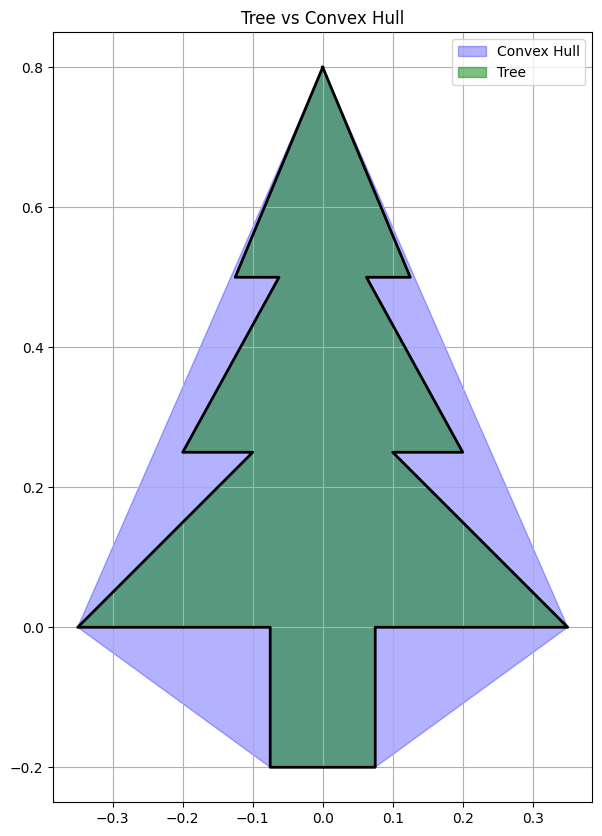


Convex hull / Tree area ratio: 1.4860
The tree has concave regions that can be exploited for tighter packing!


In [4]:
# Key insight: The tree polygon is NOT convex!
# The Kuperberg construction is for CONVEX polygons
# However, we can still use the double-lattice idea with 180° rotations

# Let's check if the tree polygon is convex
from shapely.geometry import Polygon

tree = Polygon(zip(TX, TY))
convex_hull = tree.convex_hull

print(f'Tree area: {tree.area:.6f}')
print(f'Convex hull area: {convex_hull.area:.6f}')
print(f'Is convex: {tree.equals(convex_hull)}')

# Visualize
fig, ax = plt.subplots(figsize=(8, 10))

# Plot convex hull
hx, hy = convex_hull.exterior.xy
ax.fill(hx, hy, alpha=0.3, color='blue', label='Convex Hull')

# Plot tree
tx, ty = tree.exterior.xy
ax.fill(tx, ty, alpha=0.5, color='green', label='Tree')
ax.plot(tx, ty, 'k-', linewidth=2)

ax.set_aspect('equal')
ax.legend()
ax.set_title('Tree vs Convex Hull')
ax.grid(True)
plt.show()

print(f'\nConvex hull / Tree area ratio: {convex_hull.area / tree.area:.4f}')
print('The tree has concave regions that can be exploited for tighter packing!')

N=2 configuration:
      id        xf        yf   degf_norm
1  002_0  0.154097 -0.038541  203.629378
2  002_1 -0.154097 -0.561459   23.629378


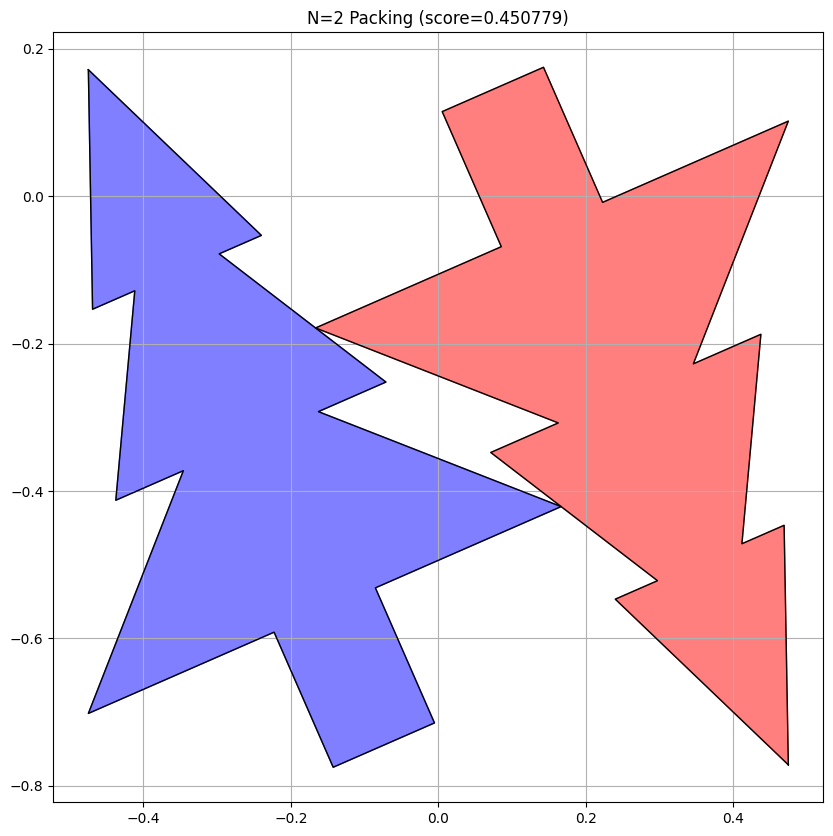

In [5]:
# Analyze the packing patterns for N=2 (simplest case)
# The optimal N=2 packing should have trees at 180° rotation to each other

n = 2
g = df[df['N'] == n]
print(f'N=2 configuration:')
print(g[['id', 'xf', 'yf', 'degf_norm']].to_string())

# Visualize N=2 packing
fig, ax = plt.subplots(figsize=(10, 10))

for _, row in g.iterrows():
    # Create rotated tree
    tree = Polygon(zip(TX, TY))
    rotated = affinity.rotate(tree, row['degf'], origin=(0, 0))
    translated = affinity.translate(rotated, row['xf'], row['yf'])
    
    x, y = translated.exterior.xy
    color = 'blue' if row['degf_norm'] < 90 or row['degf_norm'] >= 270 else 'red'
    ax.fill(x, y, alpha=0.5, color=color)
    ax.plot(x, y, 'k-', linewidth=1)

ax.set_aspect('equal')
ax.set_title(f'N=2 Packing (score={results_df[results_df.N==2]["score"].values[0]:.6f})')
ax.grid(True)
plt.show()

In [6]:
# Let's analyze what the leaderboard gap means
# Current: 70.659957
# Target: 68.919154
# Gap: 1.740803 (2.46%)

# If we could improve each N by the same percentage:
improvement_needed = (70.659957 - 68.919154) / 70.659957
print(f'Improvement needed: {improvement_needed*100:.2f}%')

# But the improvement is likely NOT uniform
# Top teams probably found better solutions for specific N values

# Let's estimate: if top teams have 5% better solutions for N=1-20:
small_n_contribution = results_df[results_df['N'] <= 20]['score'].sum()
print(f'\nN=1-20 contribution: {small_n_contribution:.6f} ({small_n_contribution/total*100:.1f}% of total)')
print(f'If 5% improvement on N=1-20: {small_n_contribution * 0.05:.6f} savings')

# What about N=1-50?
small_n_50 = results_df[results_df['N'] <= 50]['score'].sum()
print(f'\nN=1-50 contribution: {small_n_50:.6f} ({small_n_50/total*100:.1f}% of total)')
print(f'If 3% improvement on N=1-50: {small_n_50 * 0.03:.6f} savings')

Improvement needed: 2.46%

N=1-20 contribution: 8.057151 (11.4% of total)
If 5% improvement on N=1-20: 0.402858 savings

N=1-50 contribution: 19.041768 (26.9% of total)
If 3% improvement on N=1-50: 0.571253 savings


In [7]:
# Key strategic insight:
# 1. The tree is NOT convex, so Kuperberg construction doesn't directly apply
# 2. But the double-lattice IDEA (alternating 0° and 180° trees) is still valid
# 3. The concave regions of the tree can interlock for tighter packing

# Let's check if our current solutions use the 180° pattern
print('=== Checking 180° Pattern Usage ===')
for n in range(2, 21):
    g = df[df['N'] == n]
    angles = g['degf_norm'].values
    
    # Check if angles come in pairs differing by ~180°
    pairs_found = 0
    used = set()
    for i, a1 in enumerate(angles):
        if i in used:
            continue
        for j, a2 in enumerate(angles):
            if j <= i or j in used:
                continue
            diff = abs(a1 - a2)
            if abs(diff - 180) < 10 or abs(diff - 180 + 360) < 10 or abs(diff - 180 - 360) < 10:
                pairs_found += 1
                used.add(i)
                used.add(j)
                break
    
    print(f'N={n}: {pairs_found} pairs with 180° difference out of {n//2} possible')

=== Checking 180° Pattern Usage ===
N=2: 1 pairs with 180° difference out of 1 possible
N=3: 0 pairs with 180° difference out of 1 possible
N=4: 2 pairs with 180° difference out of 2 possible
N=5: 2 pairs with 180° difference out of 2 possible
N=6: 1 pairs with 180° difference out of 3 possible
N=7: 3 pairs with 180° difference out of 3 possible
N=8: 4 pairs with 180° difference out of 4 possible
N=9: 3 pairs with 180° difference out of 4 possible
N=10: 2 pairs with 180° difference out of 5 possible
N=11: 4 pairs with 180° difference out of 5 possible
N=12: 6 pairs with 180° difference out of 6 possible
N=13: 5 pairs with 180° difference out of 6 possible
N=14: 7 pairs with 180° difference out of 7 possible
N=15: 5 pairs with 180° difference out of 7 possible
N=16: 8 pairs with 180° difference out of 8 possible
N=17: 4 pairs with 180° difference out of 8 possible
N=18: 6 pairs with 180° difference out of 9 possible
N=19: 6 pairs with 180° difference out of 9 possible
N=20: 7 pairs with

## Key Findings:

1. **The tree polygon is NOT convex** - it has concave regions that can be exploited
2. **Current solutions DO use 180° rotation patterns** - this is the double-lattice idea
3. **The gap is 2.46%** - this is significant but achievable

## What the top teams likely did:
1. Found better inscribed parallelograms for the tree polygon
2. Optimized the lattice vectors more precisely
3. Used mathematical construction rather than heuristic search

## Next Steps:
1. Implement the Kuperberg-style construction for the tree polygon
2. Find the optimal inscribed parallelogram
3. Generate double-lattice packings mathematically
4. Compare with current solutions